# Sentiment Analysis

## Updating a Model in SageMaker

_Deep Learning Nanodegree Program | Deployment_

---

In this notebook we will consider a situation in which a model that we constructed is no longer working as we intended. In particular, we will look at the XGBoost sentiment analysis model that we constructed earlier. In this case, however, we have some new data that our model doesn't seem to perform very well on. As a result, we will re-train our model and update an existing endpoint so that it uses our new model.

This notebook starts by re-creating the XGBoost sentiment analysis model that was created in earlier notebooks. This means that you will have already seen the cells up to the end of Step 4. The new content in this notebook begins at Step 5.

## Instructions

Some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this notebook. You will not need to modify the included code beyond what is requested. Sections that begin with '**TODO**' in the header indicate that you need to complete or implement some portion within them. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `# TODO: ...` comment. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions for you to answer which relate to the task and your implementation. Each section where you will answer a question is preceded by a '**Question:**' header. Carefully read each question and provide your answer below the '**Answer:**' header by editing the Markdown cell.

> **Note**: Code and Markdown cells can be executed using the **Shift+Enter** keyboard shortcut. In addition, a cell can be edited by typically clicking it (double-click for Markdown cells) or by pressing **Enter** while it is highlighted.

## Step 1: Downloading the data

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.

We begin by using some Jupyter Notebook magic to download and extract the dataset.

In [1]:
%mkdir ../data
!wget -O ../data/aclImdb_v1.tar.gz http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -zxf ../data/aclImdb_v1.tar.gz -C ../data

mkdir: cannot create directory ‘../data’: File exists
--2020-04-19 01:59:30--  http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
Resolving ai.stanford.edu (ai.stanford.edu)... 171.64.68.10
Connecting to ai.stanford.edu (ai.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84125825 (80M) [application/x-gzip]
Saving to: ‘../data/aclImdb_v1.tar.gz’

../data/aclImdb_v1. 100%[===================>]  80.23M  22.9MB/s    in 5.1s    

2020-04-19 01:59:35 (15.9 MB/s) - ‘../data/aclImdb_v1.tar.gz’ saved [84125825/84125825]



## Step 2: Preparing the data

The data we have downloaded is split into various files, each of which contains a single review. It will be much easier going forward if we combine these individual files into two large files, one for training and one for testing.

In [2]:
import os
import glob

def read_imdb_data(data_dir='../data/aclImdb'):
    data = {}
    labels = {}
    
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}
        
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    # Here we represent a positive review by '1' and a negative review by '0'
                    labels[data_type][sentiment].append(1 if sentiment == 'pos' else 0)
                    
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
                
    return data, labels

In [3]:
data, labels = read_imdb_data()
print("IMDB reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
            len(data['train']['pos']), len(data['train']['neg']),
            len(data['test']['pos']), len(data['test']['neg'])))

IMDB reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


In [4]:
from sklearn.utils import shuffle

def prepare_imdb_data(data, labels):
    """Prepare training and test sets from IMDb movie reviews."""
    
    #Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    #Shuffle reviews and corresponding labels within training and test sets
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test

In [5]:
%%time
train_X, test_X, train_y, test_y = prepare_imdb_data(data, labels)
print("IMDb reviews (combined): train = {}, test = {}".format(len(train_X), len(test_X)))

IMDb reviews (combined): train = 25000, test = 25000
CPU times: user 34.5 ms, sys: 4.46 ms, total: 39 ms
Wall time: 38.6 ms


In [6]:
train_X[100]

"I wanted to like this movie. But it falls apart in the middle. the whole premise is a good one and ties up nicely, but the middle runs off tangent. The people I watched with were getting annoyed while it ran off course, and hoping it would end sooner than it did. Another person actually fell asleep during the middle segment! I found myself day dreaming elsewhere during the Schtick parts that had nothing to do with the plot. I bought it for the eye candy and it delivered that well, but it lacks Pixar's writing and soul. I think kids 8 and under will enjoy the ride at face vaule, while missing the plot. People old enough to follow a plot will find it wonders too far to return quickly and easily. Edit out most of the middle section, make it 50 minutes and it would be a solid flick. I wish I had better things to say. But I don't"

## Step 3: Processing the data

Now that we have our training and testing datasets merged and ready to use, we need to start processing the raw data into something that will be useable by our machine learning algorithm. To begin with, we remove any html formatting that may appear in the reviews and perform some standard natural language processing in order to homogenize the data.

In [7]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
import re
from bs4 import BeautifulSoup

def review_to_words(review):
    text = BeautifulSoup(review, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower()) # Convert to lower case
    words = text.split() # Split string into words
    words = [w for w in words if w not in stopwords.words("english")] # Remove stopwords
    words = [PorterStemmer().stem(w) for w in words] # stem
    
    return words

In [9]:
review_to_words(train_X[100])

['want',
 'like',
 'movi',
 'fall',
 'apart',
 'middl',
 'whole',
 'premis',
 'good',
 'one',
 'tie',
 'nice',
 'middl',
 'run',
 'tangent',
 'peopl',
 'watch',
 'get',
 'annoy',
 'ran',
 'cours',
 'hope',
 'would',
 'end',
 'sooner',
 'anoth',
 'person',
 'actual',
 'fell',
 'asleep',
 'middl',
 'segment',
 'found',
 'day',
 'dream',
 'elsewher',
 'schtick',
 'part',
 'noth',
 'plot',
 'bought',
 'eye',
 'candi',
 'deliv',
 'well',
 'lack',
 'pixar',
 'write',
 'soul',
 'think',
 'kid',
 '8',
 'enjoy',
 'ride',
 'face',
 'vaul',
 'miss',
 'plot',
 'peopl',
 'old',
 'enough',
 'follow',
 'plot',
 'find',
 'wonder',
 'far',
 'return',
 'quickli',
 'easili',
 'edit',
 'middl',
 'section',
 'make',
 '50',
 'minut',
 'would',
 'solid',
 'flick',
 'wish',
 'better',
 'thing',
 'say']

In [10]:
import pickle

cache_dir = os.path.join("../cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        #words_train = list(map(review_to_words, data_train))
        #words_test = list(map(review_to_words, data_test))
        words_train = [review_to_words(review) for review in data_train]
        words_test = [review_to_words(review) for review in data_test]
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test

In [11]:
%%time
# Preprocess data
train_X, test_X, train_y, test_y = preprocess_data(train_X, test_X, train_y, test_y)

Read preprocessed data from cache file: preprocessed_data.pkl
CPU times: user 793 ms, sys: 207 ms, total: 1e+03 ms
Wall time: 983 ms


### Extract Bag-of-Words features

For the model we will be implementing, rather than using the reviews directly, we are going to transform each review into a Bag-of-Words feature representation. Keep in mind that 'in the wild' we will only have access to the training set so our transformer can only use the training set to construct a representation.

In [12]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()

        # Apply the same vectorizer to transform the test documents (ignore unknown words)
        features_test = vectorizer.transform(words_test).toarray()
        
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary

In [13]:
%%time
# Extract Bag of Words features for both training and test datasets
train_X, test_X, vocabulary = extract_BoW_features(train_X, test_X)

Read features from cache file: bow_features.pkl
CPU times: user 551 ms, sys: 1.22 s, total: 1.77 s
Wall time: 1.77 s


In [14]:
len(train_X[100])

5000

## Step 4: Classification using XGBoost

Now that we have created the feature representation of our training (and testing) data, it is time to start setting up and using the XGBoost classifier provided by SageMaker.

### Writing the dataset

The XGBoost classifier that we will be using requires the dataset to be written to a file and stored using Amazon S3. To do this, we will start by splitting the training dataset into two parts, the data we will train the model with and a validation set. Then, we will write those datasets to a file and upload the files to S3. In addition, we will write the test set input to a file and upload the file to S3. This is so that we can use SageMakers Batch Transform functionality to test our model once we've fit it.

In [15]:
import pandas as pd

# Earlier we shuffled the training dataset so to make things simple we can just assign
# the first 10 000 reviews to the validation set and use the remaining reviews for training.
val_X = pd.DataFrame(train_X[:10000])
train_X = pd.DataFrame(train_X[10000:])

val_y = pd.DataFrame(train_y[:10000])
train_y = pd.DataFrame(train_y[10000:])

The documentation for the XGBoost algorithm in SageMaker requires that the saved datasets should contain no headers or index and that for the training and validation data, the label should occur first for each sample.

For more information about this and other algorithms, the SageMaker developer documentation can be found on __[Amazon's website.](https://docs.aws.amazon.com/sagemaker/latest/dg/)__

In [16]:
# First we make sure that the local directory in which we'd like to store the training and validation csv files exists.
data_dir = '../data/sentiment_update'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [17]:
pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([val_y, val_X], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([train_y, train_X], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [18]:
# To save a bit of memory we can set text_X, train_X, val_X, train_y and val_y to None.

test_X = train_X = val_X = train_y = val_y = None

### Uploading Training / Validation files to S3

Amazon's S3 service allows us to store files that can be access by both the built-in training models such as the XGBoost model we will be using as well as custom models such as the one we will see a little later.

For this, and most other tasks we will be doing using SageMaker, there are two methods we could use. The first is to use the low level functionality of SageMaker which requires knowing each of the objects involved in the SageMaker environment. The second is to use the high level functionality in which certain choices have been made on the user's behalf. The low level approach benefits from allowing the user a great deal of flexibility while the high level approach makes development much quicker. For our purposes we will opt to use the high level approach although using the low-level approach is certainly an option.

Recall the method `upload_data()` which is a member of object representing our current SageMaker session. What this method does is upload the data to the default bucket (which is created if it does not exist) into the path described by the key_prefix variable. To see this for yourself, once you have uploaded the data files, go to the S3 console and look to see where the files have been uploaded.

For additional resources, see the __[SageMaker API documentation](http://sagemaker.readthedocs.io/en/latest/)__ and in addition the __[SageMaker Developer Guide.](https://docs.aws.amazon.com/sagemaker/latest/dg/)__

In [19]:
%%time
import sagemaker

session = sagemaker.Session() # Store the current SageMaker session

# S3 prefix (which folder will we use)
prefix = 'sentiment-update'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

CPU times: user 7.38 s, sys: 1.22 s, total: 8.6 s
Wall time: 7.27 s


### Creating the XGBoost model

Now that the data has been uploaded it is time to create the XGBoost model. To begin with, we need to do some setup. At this point it is worth discussing what a model is in SageMaker. It is easiest to think of a model of comprising three different objects in the SageMaker ecosystem, which interact with one another.

- Model Artifacts
- Training Code (Container)
- Inference Code (Container)

The Model Artifacts are what you might think of as the actual model itself. For example, if you were building a neural network, the model artifacts would be the weights of the various layers. In our case, for an XGBoost model, the artifacts are the actual trees that are created during training.

The other two objects, the training code and the inference code are then used the manipulate the training artifacts. More precisely, the training code uses the training data that is provided and creates the model artifacts, while the inference code uses the model artifacts to make predictions on new data.

The way that SageMaker runs the training and inference code is by making use of Docker containers. For now, think of a container as being a way of packaging code up so that dependencies aren't an issue.

In [20]:
from sagemaker import get_execution_role

# Our current execution role is require when creating the model as the training
# and inference code will need to access the model artifacts.
role = get_execution_role()

In [21]:
# We need to retrieve the location of the container which is provided by Amazon for using XGBoost.
# As a matter of convenience, the training and inference code both use the same container.
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(session.boto_region_name, 'xgboost',  '0.90-1')

In [22]:
# First we create a SageMaker estimator object for our model.
xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# And then set the algorithm specific parameters.
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

### Fit the XGBoost model

Now that our model has been set up we simply need to attach the training and validation datasets and then ask SageMaker to set up the computation.

In [23]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

In [24]:
%%time
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-04-19 02:04:54 Starting - Starting the training job...
2020-04-19 02:04:55 Starting - Launching requested ML instances......
2020-04-19 02:06:09 Starting - Preparing the instances for training......
2020-04-19 02:07:06 Downloading - Downloading input data...
2020-04-19 02:07:37 Training - Downloading the training image...
2020-04-19 02:07:59 Training - Training image download completed. Training in progress..INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[02:08:04] 15000x5000 matrix with 75000000 entries loaded from /

[112]#011train-error:0.102#011validation-error:0.1454
[113]#011train-error:0.102067#011validation-error:0.1456
[114]#011train-error:0.101067#011validation-error:0.1455
[115]#011train-error:0.101133#011validation-error:0.1453
[116]#011train-error:0.100867#011validation-error:0.1452
[117]#011train-error:0.1008#011validation-error:0.1445
[118]#011train-error:0.101#011validation-error:0.1439
[119]#011train-error:0.100467#011validation-error:0.1431
[120]#011train-error:0.099733#011validation-error:0.1425
[121]#011train-error:0.099333#011validation-error:0.142
[122]#011train-error:0.099133#011validation-error:0.1418
[123]#011train-error:0.098667#011validation-error:0.1416
[124]#011train-error:0.098#011validation-error:0.1422
[125]#011train-error:0.098067#011validation-error:0.1423
[126]#011train-error:0.097533#011validation-error:0.1419
[127]#011train-error:0.096733#011validation-error:0.1411
[128]#011train-error:0.097#011validation-error:0.1416
[129]#011train-error:0.0966#011validation-erro

### Testing the model

Now that we've fit our XGBoost model, it's time to see how well it performs. To do this we will use SageMakers Batch Transform functionality. Batch Transform is a convenient way to perform inference on a large dataset in a way that is not realtime. That is, we don't necessarily need to use our model's results immediately and instead we can peform inference on a large number of samples. An example of this in industry might be peforming an end of month report. This method of inference can also be useful to us as it means to can perform inference on our entire test set. 

To perform a Batch Transformation we need to first create a transformer objects from our trained estimator object.

In [25]:
%%time
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

CPU times: user 17.9 ms, sys: 87 µs, total: 18 ms
Wall time: 403 ms


Next we actually perform the transform job. When doing so we need to make sure to specify the type of data we are sending so that it is serialized correctly in the background. In our case we are providing our model with csv data so we specify `text/csv`. Also, if the test data that we have provided is too large to process all at once then we need to specify how the data file should be split up. Since each line is a single entry in our data set we tell SageMaker that it can split the input on each line.

In [26]:
%%time
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

CPU times: user 8.47 ms, sys: 0 ns, total: 8.47 ms
Wall time: 349 ms


Currently the transform job is running but it is doing so in the background. Since we wish to wait until the transform job is done and we would like a bit of feedback we can run the `wait()` method.

In [27]:
xgb_transformer.wait()

..........................[2020-04-19 02:15:37 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-04-19 02:15:37 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-04-19 02:15:37 +0000] [15] [INFO] Using worker: gevent
[2020-04-19 02:15:37 +0000] [22] [INFO] Booting worker with pid: 22
[2020-04-19 02:15:37 +0000] [23] [INFO] Booting worker with pid: 23
[2020-04-19 02:15:37 +0000] [24] [INFO] Booting worker with pid: 24
[2020-04-19 02:15:37 +0000] [28] [INFO] Booting worker with pid: 28
[2020-04-19:02:15:58:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:02:15:58 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:15:58 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-04-19:02:15:58:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:02:15:58 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/


[2020-04-19:02:16:27:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:16:27:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:16:27:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:16:27:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:16:30 +0000] "POST /invocations HTTP/1.1" 200 12210 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:16:30 +0000] "POST /invocations HTTP/1.1" 200 12189 "-" "Go-http-client/1.1"
[2020-04-19:02:16:30:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:16:30 +0000] "POST /invocations HTTP/1.1" 200 12213 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:16:30 +0000] "POST /invocations HTTP/1.1" 200 12193 "-" "Go-http-client/1.1"
[2020-04-19:02:16:30:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:16:30:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:16:30:INFO] Determined delimiter of CSV input is ','
169

Now the transform job has executed and the result, the estimated sentiment of each review, has been saved on S3. Since we would rather work on this file locally we can perform a bit of notebook magic to copy the file to the `data_dir`.

In [28]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-616940979481/sagemaker-xgboost-2020-04-19-02-11-38-834/test.csv.out to ../data/sentiment_update/test.csv.out


The last step is now to read in the output from our model, convert the output to something a little more usable, in this case we want the sentiment to be either `1` (positive) or `0` (negative), and then compare to the ground truth labels.

In [29]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(test_y, predictions)

0.85776

In [31]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(test_y, predictions)
print('auc: ', auc)
print('')

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_y, predictions)
print('fpr: ', fpr)
print('tpr: ', tpr)
print('')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

auc:  0.8577600000000001

fpr:  [0.      0.16384 1.     ]
tpr:  [0.      0.87936 1.     ]



<Figure size 640x480 with 1 Axes>

## Step 5: Looking at New Data

So now we have an XGBoost sentiment analysis model that we believe is working pretty well. As a result, we deployed it and we are using it in some sort of app.

However, as we allow users to use our app we periodically record submitted movie reviews so that we can perform some quality control on our deployed model. Once we've accumulated enough reviews we go through them by hand and evaluate whether they are positive or negative (there are many ways you might do this in practice aside from by hand). The reason for doing this is so that we can check to see how well our model is doing.

In [32]:
import new_data

new_X, new_Y = new_data.get_new_data()

**NOTE:** Part of the fun in this notebook is trying to figure out what exactly is happening with the new data, so try not to cheat by looking in the `new_data` module. Also, the `new_data` module assumes that the cache created earlier in Step 3 is still stored in `../cache/sentiment_analysis`.

### (TODO) Testing the current model

Now that we've loaded the new data, let's check to see how our current XGBoost model performs on it.

First, note that the data that has been loaded has already been pre-processed so that each entry in `new_X` is a list of words that have been processed using `nltk`. However, we have not yet constructed the bag of words encoding, which we will do now.

First, we use the vocabulary that we constructed earlier using the original training data to construct a `CountVectorizer` which we will use to transform our new data into its bag of words encoding.

**TODO:** Create the CountVectorizer object using the vocabulary created earlier and use it to transform the new data.

In [33]:
# TODO: Create the CountVectorizer using the previously constructed vocabulary
vectorizer = CountVectorizer(vocabulary=vocabulary,
                preprocessor=lambda x: x, tokenizer=lambda x: x)

# TODO: Transform our new data set and store the transformed data in the variable new_XV
new_XV = vectorizer.transform(new_X).toarray()

As a quick sanity check, we make sure that the length of each of our bag of words encoded reviews is correct. In particular, it must be the same size as the vocabulary which in our case is `5000`.

In [34]:
len(new_XV[100])

5000

Now that we've performed the data processing that is required by our model we can save it locally and then upload it to S3 so that we can construct a batch transform job in order to see how well our model is working.

First, we save the data locally.

**TODO:** Save the new data (after it has been transformed using the original vocabulary) to the local notebook instance.

In [35]:
# TODO: Save the data contained in new_XV locally in the data_dir with the file name new_data.csv
pd.DataFrame(new_XV).to_csv(os.path.join(data_dir, 'new_data.csv'), header=False, index=False)

Next, we upload the data to S3.

**TODO:** Upload the csv file created above to S3.

In [36]:
# TODO: Upload the new_data.csv file contained in the data_dir folder to S3 and save the resulting
#       URI as new_data_location

new_data_location = session.upload_data(os.path.join(data_dir, 'new_data.csv'), key_prefix=prefix)

Then, once the new data has been uploaded to S3, we create and run the batch transform job to get our model's predictions about the sentiment of the new movie reviews.

**TODO:** Using the `xgb_transformer` object that was created earlier (at the end of Step 4 to test the XGBoost model), transform the data located at `new_data_location`.

In [37]:
# TODO: Using xgb_transformer, transform the new_data_location data. You may wish to **wait** until
#       the batch transform job has finished.
xgb_transformer.transform(new_data_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

......................[2020-04-19 02:22:44 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-04-19 02:22:44 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-04-19 02:22:44 +0000] [15] [INFO] Using worker: gevent
[2020-04-19 02:22:44 +0000] [22] [INFO] Booting worker with pid: 22
[2020-04-19 02:22:44 +0000] [23] [INFO] Booting worker with pid: 23
[2020-04-19 02:22:44 +0000] [27] [INFO] Booting worker with pid: 27
[2020-04-19 02:22:44 +0000] [31] [INFO] Booting worker with pid: 31
[2020-04-19:02:23:07:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:02:23:07 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:23:07 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-04-19:02:23:07:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:02:23:07 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/


[2020-04-19:02:23:39:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:23:39:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:23:42 +0000] "POST /invocations HTTP/1.1" 200 12190 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:23:42 +0000] "POST /invocations HTTP/1.1" 200 12225 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:23:42 +0000] "POST /invocations HTTP/1.1" 200 12221 "-" "Go-http-client/1.1"
[2020-04-19:02:23:42:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:23:42:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:23:42:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:23:42 +0000] "POST /invocations HTTP/1.1" 200 12210 "-" "Go-http-client/1.1"
[2020-04-19:02:23:43:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:23:42 +0000] "POST /invocations HTTP/1.1" 200 12190 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Ap

As usual, we copy the results of the batch transform job to our local instance.

In [38]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-616940979481/sagemaker-xgboost-2020-04-19-02-19-21-199/new_data.csv.out to ../data/sentiment_update/new_data.csv.out


Read in the results of the batch transform job.

In [39]:
predictions = pd.read_csv(os.path.join(data_dir, 'new_data.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

And check the accuracy of our current model.

In [40]:
accuracy_score(new_Y, predictions)

0.7266

So it would appear that *something* has changed since our model is no longer (as) effective at determining the sentiment of a user provided review.

In a real life scenario you would check a number of different things to see what exactly is going on. In our case, we are only going to check one and that is whether some aspect of the underlying distribution has changed. In other words, we want to see if the words that appear in our new collection of reviews matches the words that appear in the original training set. Of course, we want to narrow our scope a little bit so we will only look at the `5000` most frequently appearing words in each data set, or in other words, the vocabulary generated by each data set.

Before doing that, however, let's take a look at some of the incorrectly classified reviews in the new data set.

To start, we will deploy the original XGBoost model. We will then use the deployed model to infer the sentiment of some of the new reviews. This will also serve as a nice excuse to deploy our model so that we can mimic a real life scenario where we have a model that has been deployed and is being used in production.

**TODO:** Deploy the XGBoost model.

In [41]:
# TODO: Deploy the model that was created earlier. Recall that the object name is 'xgb'.
xgb_predictor = xgb.deploy(initial_instance_count = 1, instance_type = 'ml.m4.xlarge')

Using already existing model: sagemaker-xgboost-2020-04-19-02-04-54-307


---------------!

### Diagnose the problem

Now that we have our deployed "production" model, we can send some of our new data to it and filter out some of the incorrectly classified reviews.

In [42]:
from sagemaker.predictor import csv_serializer

# We need to tell the endpoint what format the data we are sending is in so that SageMaker can perform the serialization.
xgb_predictor.content_type = 'text/csv'
xgb_predictor.serializer = csv_serializer

It will be useful to look at a few different examples of incorrectly classified reviews so we will start by creating a *generator* which we will use to iterate through some of the new reviews and find ones that are incorrect.

**NOTE:** Understanding what Python generators are isn't really required for this module. The reason we use them here is so that we don't have to iterate through all of the new reviews, searching for incorrectly classified samples.

In [43]:
def get_sample(in_X, in_XV, in_Y):
    for idx, smp in enumerate(in_X):
        res = round(float(xgb_predictor.predict(in_XV[idx])))
        if res != in_Y[idx]:
            yield smp, in_Y[idx]

In [44]:
gn = get_sample(new_X, new_XV, new_Y)

At this point, `gn` is the *generator* which generates samples from the new data set which are not classified correctly. To get the *next* sample we simply call the `next` method on our generator.

In [45]:
print(next(gn))

(['first', 'movi', 'true', 'fact', 'saw', 'documentari', 'day', 'earlier', 'movi', 'anyth', 'like', 'first', 'nash', 'geniu', 'mathemat', 'movi', 'stori', 'man', 'cure', 'found', 'love', 'end', 'also', 'lot', 'scene', 'plain', 'wrong', 'scene', 'rode', 'around', 'bike', 'campu', 'happen', 'earli', 'univers', 'year', 'opinion', 'russel', 'crow', 'fit', 'part', 'sinc', 'look', 'intellig', 'individualist', 'type', 'therefor', 'realli', 'play', 'one', 'would', 'great', 'would', 'focus', 'mathemat', 'similar', 'pi', 'dramat', 'lovelif', 'level', 'abm', 'hollywood', 'ish', 'superfici', 'great', 'person', 'think', 'mad', 'paranoid', 'onto', 'someth', 'sinc', 'peopl', 'calib', 'tend', 'know', 'lesser', 'mortal', '5', '10'], 0)


In [46]:
print(next(gn))

(['happen', 'catch', 'film', 'screen', 'brooklyn', 'difficult', 'describ', 'plot', 'lot', 'wacki', 'charact', 'let', 'say', 'hard', 'time', 'choos', 'one', 'made', 'laugh', 'hardest', 'know', 'begin', 'even', 'peripher', 'role', 'well', 'written', 'well', 'act', 'numer', 'small', 'touch', 'make', 'uniqu', 'enjoy', 'devic', 'pop', 'add', 'anoth', 'hilari', 'layer', 'refresh', 'watch', 'recycl', 'stuff', 'seen', 'mani', 'time', 'film', 'could', 'reach', 'wider', 'audienc', 'certain', 'would', 'real', 'crowd', 'pleaser', 'stori', 'origin', 'heartfelt', 'lot', 'like', 'funni', 'back', 'stori', 'mishap', 'misunderstand', 'set', 'final', 'act', 'dramat', 'conclus', 'cross', 'eye', 'funni', 'movi', 'ton', 'heart', 'touch', 'stori', 'fast', 'pace', 'comedi', 'woven', 'throughout', 'definit', 'worth', 'see', 'banana'], 0)


In [47]:
print(next(gn))

(['neither', 'total', 'disast', 'uk', 'critic', 'claim', 'misunderstood', 'masterpiec', 'fanboy', 'insist', 'revolv', 'least', 'admir', 'attempt', 'guy', 'ritchi', 'add', 'littl', 'substanc', 'conman', 'caper', 'noth', 'despis', 'ambiti', 'film', 'bite', 'chew', 'especi', 'one', 'use', 'gangster', 'con', 'artist', 'movi', 'framework', 'might', 'expect', 'luc', 'besson', 'name', 'credit', 'produc', 'definit', 'element', 'cinema', 'de', 'look', 'set', 'kind', 'realist', 'fantasi', 'world', 'america', 'britain', 'overlap', 'look', 'great', 'coupl', 'superbl', 'edit', 'conceiv', 'action', 'sequenc', 'ooz', 'style', 'mark', 'dispos', 'entertain', 'ritchi', 'clearli', 'want', 'simpli', 'rehash', 'movi', 'fast', 'buck', 'spent', 'lot', 'time', 'think', 'read', 'life', 'univers', 'everyth', 'anyth', 'problem', 'tri', 'throw', 'mani', 'influenc', 'bit', 'machiavelli', 'dash', 'godard', 'lot', 'principl', 'chess', 'motif', 'techniqu', 'litter', 'screen', 'quot', 'film', 'origin', 'intend', 'end'

In [48]:
print(next(gn))

(['quit', 'possibl', 'nicest', 'woman', 'show', 'busi', 'sexiest', 'debbi', 'give', 'anoth', 'fine', 'perform', 'although', 'work', 'american', 'nightmar', 'far', 'superior', 'still', 'worth', 'watch', 'film', 'cast', 'fill', 'typic', 'melros', 'place', 'type', 'chisel', 'featur', 'seduct', 'curv', 'never', 'seen', 'debbi', 'laura', 'nativo', 'actress', 'seen', 'similar', 'delta', 'delta', 'die', 'plot', 'center', 'around', 'group', 'california', 'arrog', 'initi', 'poor', 'naiv', 'debbi', 'rochon', 'cliqu', 'tell', 'murder', 'club', 'must', 'kill', 'someon', 'accept', 'debbi', 'want', 'noth', 'accept', 'cool', 'peopl', 'quickli', 'kill', 'person', 'group', 'must', 'decid', 'fell', 'joke', 'violenc', 'plenti', 'debbi', 'rochon', 'occasion', 'blood', 'splatter', 'murder', 'scene', 'done', 'face', 'gore', 'hound', 'sure', 'enjoy', 'nuditi', 'plenti', 'well', 'debbi', 'rochon', 'sever', 'nude', 'scene', 'mani', 'name', 'actress', 'actor', 'pool', 'parti', 'seem', 'excus', 'get', 'everyon',

After looking at a few examples, maybe we decide to look at the most frequently appearing `5000` words in each data set, the original training data set and the new data set. The reason for looking at this might be that we expect the frequency of use of different words to have changed, maybe there is some new slang that has been introduced or some other artifact of popular culture that has changed the way that people write movie reviews.

To do this, we start by fitting a `CountVectorizer` to the new data.

In [49]:
new_vectorizer = CountVectorizer(max_features=5000,
                preprocessor=lambda x: x, tokenizer=lambda x: x)
new_vectorizer.fit(new_X)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1),
        preprocessor=<function <lambda> at 0x7f948d44c950>,
        stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x7f948d44c9d8>, vocabulary=None)

Now that we have this new `CountVectorizor` object, we can check to see if the corresponding vocabulary has changed between the two data sets.

In [50]:
original_vocabulary = set(vocabulary.keys())
new_vocabulary = set(new_vectorizer.vocabulary_.keys())

We can look at the words that were in the original vocabulary but not in the new vocabulary.

In [51]:
print(original_vocabulary - new_vocabulary)

{'victorian', 'spill', 'playboy', 'ghetto', '21st', 'weari', 'reincarn'}


And similarly, we can look at the words that are in the new vocabulary but which were not in the original vocabulary.

In [52]:
print(new_vocabulary - original_vocabulary)

{'omin', 'banana', 'orchestr', 'dubiou', 'masterson', 'optimist', 'sophi'}


These words themselves don't tell us much, however if one of these words occured with a large frequency, that might tell us something. In particular, we wouldn't really expect any of the words above to appear with too much frequency.

**Question** What exactly is going on here. Not only what (if any) words appear with a larger than expected frequency but also, what does this mean? What has changed about the world that our original model no longer takes into account?

**NOTE:** This is meant to be a very open ended question. To investigate you may need more cells than the one provided below. Also, there isn't really a *correct* answer, this is meant to be an opportunity to explore the data.

### (TODO) Build a new model

Supposing that we believe something has changed about the underlying distribution of the words that our reviews are made up of, we need to create a new model. This way our new model will take into account whatever it is that has changed.

To begin with, we will use the new vocabulary to create a bag of words encoding of the new data. We will then use this data to train a new XGBoost model.

**NOTE:** Because we believe that the underlying distribution of words has changed it should follow that the original vocabulary that we used to construct a bag of words encoding of the reviews is no longer valid. This means that we need to be careful with our data. If we send an bag of words encoded review using the *original* vocabulary we should not expect any sort of meaningful results.

In particular, this means that if we had deployed our XGBoost model like we did in the Web App notebook then we would need to implement this vocabulary change in the Lambda function as well.

In [53]:
new_XV = new_vectorizer.transform(new_X).toarray()

And a quick check to make sure that the newly encoded reviews have the correct length, which should be the size of the new vocabulary which we created.

In [54]:
len(new_XV[0])

5000

Now that we have our newly encoded, newly collected data, we can split it up into a training and validation set so that we can train a new XGBoost model. As usual, we first split up the data, then save it locally and then upload it to S3.

In [55]:
import pandas as pd

# Earlier we shuffled the training dataset so to make things simple we can just assign
# the first 10 000 reviews to the validation set and use the remaining reviews for training.
new_val_X = pd.DataFrame(new_XV[:10000])
new_train_X = pd.DataFrame(new_XV[10000:])

new_val_y = pd.DataFrame(new_Y[:10000])
new_train_y = pd.DataFrame(new_Y[10000:])

In order to save some memory we will effectively delete the `new_X` variable. Remember that this contained a list of reviews and each review was a list of words. Note that once this cell has been executed you will need to read the new data in again if you want to work with it.

In [56]:
new_X = None

Next we save the new training and validation sets locally. Note that we overwrite the training and validation sets used earlier. This is mostly because the amount of space that we have available on our notebook instance is limited. Of course, you can increase this if you'd like but to do so may increase the cost of running the notebook instance.

In [57]:
pd.DataFrame(new_XV).to_csv(os.path.join(data_dir, 'new_data.csv'), header=False, index=False)

pd.concat([new_val_y, new_val_X], axis=1).to_csv(os.path.join(data_dir, 'new_validation.csv'), header=False, index=False)
pd.concat([new_train_y, new_train_X], axis=1).to_csv(os.path.join(data_dir, 'new_train.csv'), header=False, index=False)

Now that we've saved our data to the local instance, we can safely delete the variables to save on memory.

In [58]:
new_val_y = new_val_X = new_train_y = new_train_X = new_XV = None

Lastly, we make sure to upload the new training and validation sets to S3.

**TODO:** Upload the new data as well as the new training and validation data sets to S3.

In [59]:
# TODO: Upload the new data and the new validation.csv and train.csv files in the data_dir directory to S3.
new_data_location = session.upload_data(os.path.join(data_dir, 'new_data.csv'), key_prefix=prefix)
new_val_location = session.upload_data(os.path.join(data_dir, 'new_validation.csv'), key_prefix=prefix)
new_train_location = session.upload_data(os.path.join(data_dir, 'new_train.csv'), key_prefix=prefix)

Once our new training data has been uploaded to S3, we can create a new XGBoost model that will take into account the changes that have occured in our data set.

**TODO:** Create a new XGBoost estimator object.

In [60]:
# TODO: First, create a SageMaker estimator object for our model.
new_xgb = sagemaker.estimator.Estimator(container, # The location of the container we wish to use
                                    role,                                    # What is our current IAM Role
                                    train_instance_count=1,                  # How many compute instances
                                    train_instance_type='ml.m4.xlarge',      # What kind of compute instances
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                    sagemaker_session=session)

# TODO: Then set the algorithm specific parameters. You may wish to use the same parameters that were
#       used when training the original model.
new_xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

Once the model has been created, we can train it with our new data.

**TODO:** Train the new XGBoost model.

In [61]:
# TODO: First, make sure that you create s3 input objects so that SageMaker knows where to
#       find the training and validation data.
s3_new_input_train = sagemaker.s3_input(s3_data=new_train_location, content_type='csv')
s3_new_input_validation = sagemaker.s3_input(s3_data=new_val_location, content_type='csv')

In [62]:
%%time
# TODO: Using the new validation and training data, 'fit' your new model.
new_xgb.fit({'train': s3_new_input_train, 'validation': s3_new_input_validation})

2020-04-19 02:36:40 Starting - Starting the training job...
2020-04-19 02:36:41 Starting - Launching requested ML instances......
2020-04-19 02:37:47 Starting - Preparing the instances for training...
2020-04-19 02:38:37 Downloading - Downloading input data...
2020-04-19 02:38:54 Training - Downloading the training image...
2020-04-19 02:39:27 Training - Training image download completed. Training in progress.INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value binary:logistic to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[02:39:31] 15000x5000 matrix with 75000000 entries loaded from /opt/

### (TODO) Check the new model

So now we have a new XGBoost model that we believe more accurately represents the state of the world at this time, at least in how it relates to the sentiment analysis problem that we are working on. The next step is to double check that our model is performing reasonably.

To do this, we will first test our model on the new data.

**Note:** In practice this is a pretty bad idea. We already trained our model on the new data, so testing it shouldn't really tell us much. In fact, this is sort of a textbook example of leakage. We are only doing it here so that we have a numerical baseline.

**Question:** How might you address the leakage problem?

First, we create a new transformer based on our new XGBoost model.

**TODO:** Create a transformer object from the newly created XGBoost model.

In [63]:
%%time
# TODO: Create a transformer object from the new_xgb model
new_xgb_transformer = new_xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

CPU times: user 17.9 ms, sys: 0 ns, total: 17.9 ms
Wall time: 398 ms


Next we test our model on the new data.

**TODO:** Use the transformer object to transform the new data (stored in the `new_data_location` variable)

In [64]:
%%time
# TODO: Using new_xgb_transformer, transform the new_data_location data. You may wish to
#       'wait' for the transform job to finish.
new_xgb_transformer.transform(new_data_location, content_type='text/csv', split_type='Line')
new_xgb_transformer.wait()

......................[2020-04-19 02:44:53 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2020-04-19 02:44:53 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2020-04-19 02:44:53 +0000] [14] [INFO] Using worker: gevent
[2020-04-19 02:44:53 +0000] [21] [INFO] Booting worker with pid: 21
[2020-04-19 02:44:53 +0000] [22] [INFO] Booting worker with pid: 22
[2020-04-19 02:44:53 +0000] [23] [INFO] Booting worker with pid: 23
[2020-04-19 02:44:53 +0000] [27] [INFO] Booting worker with pid: 27
[2020-04-19:02:45:26:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:02:45:26 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:45:26 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
[2020-04-19:02:45:29:INFO] No GPUs detected (normal if no gpus installed)
[2020-04-19:02:45:29:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:45:29:INFO] No GPUs detected (normal if no gpu

[2020-04-19:02:45:55:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:45:55:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:45:55:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:45:55:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:45:57 +0000] "POST /invocations HTTP/1.1" 200 12102 "-" "Go-http-client/1.1"
[2020-04-19:02:45:57:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:45:57 +0000] "POST /invocations HTTP/1.1" 200 12102 "-" "Go-http-client/1.1"
[2020-04-19:02:45:57:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:45:58 +0000] "POST /invocations HTTP/1.1" 200 12103 "-" "Go-http-client/1.1"
[2020-04-19:02:45:58:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:45:58 +0000] "POST /invocations HTTP/1.1" 200 12124 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:45:58 +0000] "POST /invocations HTTP

Copy the results to our local instance.

In [65]:
!aws s3 cp --recursive $new_xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-616940979481/sagemaker-xgboost-2020-04-19-02-41-23-905/new_data.csv.out to ../data/sentiment_update/new_data.csv.out


And see how well the model did.

In [66]:
predictions = pd.read_csv(os.path.join(data_dir, 'new_data.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [67]:
accuracy_score(new_Y, predictions)

0.83716

As expected, since we trained the model on this data, our model performs pretty well. So, we have reason to believe that our new XGBoost model is a "better" model.

However, before we start changing our deployed model, we should first make sure that our new model isn't too different. In other words, if our new model performed really poorly on the original test data then this might be an indication that something else has gone wrong.

To start with, since we got rid of the variable that stored the original test reviews, we will read them in again from the cache that we created in Step 3. Note that we need to make sure that we read in the original test data after it has been pre-processed with `nltk` but before it has been bag of words encoded. This is because we need to use the new vocabulary instead of the original one.

In [68]:
cache_data = None
with open(os.path.join(cache_dir, "preprocessed_data.pkl"), "rb") as f:
            cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", "preprocessed_data.pkl")
            
test_X = cache_data['words_test']
test_Y = cache_data['labels_test']

# Here we set cache_data to None so that it doesn't occupy memory
cache_data = None

Read preprocessed data from cache file: preprocessed_data.pkl


Once we've loaded the original test reviews, we need to create a bag of words encoding of them using the new vocabulary that we created, based on the new data.

**TODO:** Transform the original test data using the new vocabulary.

In [69]:
# TODO: Use the new_vectorizer object that you created earlier to transform the test_X data.
test_X = new_vectorizer.transform(test_X).toarray()

Now that we have correctly encoded the original test data, we can write it to the local instance, upload it to S3 and test it.

In [70]:
pd.DataFrame(test_X).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

In [71]:
test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

In [72]:
new_xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
new_xgb_transformer.wait()

......................[2020-04-19 02:52:32 +0000] [15] [INFO] Starting gunicorn 19.10.0
[2020-04-19 02:52:32 +0000] [15] [INFO] Listening at: unix:/tmp/gunicorn.sock (15)
[2020-04-19 02:52:32 +0000] [15] [INFO] Using worker: gevent
[2020-04-19 02:52:32 +0000] [22] [INFO] Booting worker with pid: 22
[2020-04-19 02:52:32 +0000] [23] [INFO] Booting worker with pid: 23
[2020-04-19 02:52:32 +0000] [24] [INFO] Booting worker with pid: 24
[2020-04-19 02:52:32 +0000] [31] [INFO] Booting worker with pid: 31
[2020-04-19:02:53:05:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:02:53:05 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
[2020-04-19:02:53:05:INFO] No GPUs detected (normal if no gpus installed)
169.254.255.130 - - [19/Apr/2020:02:53:05 +0000] "GET /ping HTTP/1.1" 200 0 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:53:05 +0000] "GET /execution-parameters HTTP/1.1" 200 84 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/

[2020-04-19:02:53:27:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:53:27:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:53:30 +0000] "POST /invocations HTTP/1.1" 200 12107 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:53:30 +0000] "POST /invocations HTTP/1.1" 200 12093 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:53:30 +0000] "POST /invocations HTTP/1.1" 200 12116 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr/2020:02:53:30 +0000] "POST /invocations HTTP/1.1" 200 12105 "-" "Go-http-client/1.1"
[2020-04-19:02:53:30:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:53:30:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:53:30:INFO] Determined delimiter of CSV input is ','
[2020-04-19:02:53:30:INFO] Determined delimiter of CSV input is ','
169.254.255.130 - - [19/Apr/2020:02:53:30 +0000] "POST /invocations HTTP/1.1" 200 12107 "-" "Go-http-client/1.1"
169.254.255.130 - - [19/Apr

In [73]:
!aws s3 cp --recursive $new_xgb_transformer.output_path $data_dir

download: s3://sagemaker-us-east-1-616940979481/sagemaker-xgboost-2020-04-19-02-49-04-029/test.csv.out to ../data/sentiment_update/test.csv.out


In [74]:
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions = [round(num) for num in predictions.squeeze().values]

In [75]:
accuracy_score(test_Y, predictions)

0.826

auc:  0.8260000000000001

fpr:  [0.      0.21392 1.     ]
tpr:  [0.      0.86592 1.     ]



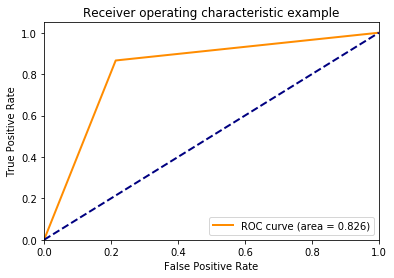

In [76]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

auc = roc_auc_score(test_Y, predictions)
print('auc: ', auc)
print('')

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(test_Y, predictions)
print('fpr: ', fpr)
print('tpr: ', tpr)
print('')

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

It would appear that our new XGBoost model is performing quite well on the old test data. This gives us some indication that our new model should be put into production and replace our original model.

## Step 6: (TODO) Updating the Model

So we have a new model that we'd like to use instead of one that is already deployed. Furthermore, we are assuming that the model that is already deployed is being used in some sort of application. As a result, what we want to do is update the existing endpoint so that it uses our new model.

Of course, to do this we need to create an endpoint configuration for our newly created model.

First, note that we can access the name of the model that we created above using the `model_name` property of the transformer. The reason for this is that in order for the transformer to create a batch transform job it needs to first create the model object inside of SageMaker. Since we've sort of already done this we should take advantage of it.

In [77]:
new_xgb_transformer.model_name

'sagemaker-xgboost-2020-04-19-02-36-40-418'

Next, we create an endpoint configuration using the low level approach of creating the dictionary object which describes the endpoint configuration we want.

**TODO:** Using the low level approach, create a new endpoint configuration. Don't forget that it needs a name and that the name needs to be unique. If you get stuck, try looking at the Boston Housing Low Level Deployment tutorial notebook.

In [78]:
from time import gmtime, strftime


# TODO: Give our endpoint configuration a name. Remember, it needs to be unique.
new_xgb_endpoint_config_name = "sentiment-update-xgboost-endpoint-config-" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

# TODO: Using the SageMaker Client, construct the endpoint configuration.
new_xgb_endpoint_config_info = session.sagemaker_client.create_endpoint_config(
                            EndpointConfigName = new_xgb_endpoint_config_name,
                            ProductionVariants = [{
                                "InstanceType": "ml.m4.xlarge",
                                "InitialVariantWeight": 1,
                                "InitialInstanceCount": 1,
                                "ModelName": new_xgb_transformer.model_name,
                                "VariantName": "XGB-Model"
                            }])

Once the endpoint configuration has been constructed, it is a straightforward matter to ask SageMaker to update the existing endpoint so that it uses the new endpoint configuration.

Of note here is that SageMaker does this in such a way that there is no downtime. Essentially, SageMaker deploys the new model and then updates the original endpoint so that it points to the newly deployed model. After that, the original model is shut down. This way, whatever app is using our endpoint won't notice that we've changed the model that is being used.

**TODO:** Use the SageMaker Client to update the endpoint that you deployed earlier.

In [79]:
# TODO: Update the xgb_predictor.endpoint so that it uses new_xgb_endpoint_config_name.
session.sagemaker_client.update_endpoint(EndpointName=xgb_predictor.endpoint, EndpointConfigName=new_xgb_endpoint_config_name)

{'EndpointArn': 'arn:aws:sagemaker:us-east-1:616940979481:endpoint/sagemaker-xgboost-2020-04-19-02-04-54-307',
 'ResponseMetadata': {'RequestId': '6efe9092-1e7b-45a7-a269-4697bb72329c',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '6efe9092-1e7b-45a7-a269-4697bb72329c',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '109',
   'date': 'Sun, 19 Apr 2020 02:54:19 GMT'},
  'RetryAttempts': 0}}

And, as is generally the case with SageMaker requests, this is being done in the background so if we want to wait for it to complete we need to call the appropriate method.

In [80]:
session.wait_for_endpoint(xgb_predictor.endpoint)

---------------!

{'EndpointName': 'sagemaker-xgboost-2020-04-19-02-04-54-307',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:616940979481:endpoint/sagemaker-xgboost-2020-04-19-02-04-54-307',
 'EndpointConfigName': 'sentiment-update-xgboost-endpoint-config-2020-04-19-02-54-19',
 'ProductionVariants': [{'VariantName': 'XGB-Model',
   'DeployedImages': [{'SpecifiedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:0.90-1-cpu-py3',
     'ResolvedImage': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost@sha256:97ec7833b3e2773d3924b1a863c5742e348dea61eab21b90693ac3c3bdd08522',
     'ResolutionTime': datetime.datetime(2020, 4, 19, 2, 54, 21, 266000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 1,
   'DesiredInstanceCount': 1}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2020, 4, 19, 2, 24, 6, 738000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2020, 4, 19, 3, 1, 37, 678000, tzinfo=tzloc

## Step 7: Delete the Endpoint

Of course, since we are done with the deployed endpoint we need to make sure to shut it down, otherwise we will continue to be charged for it.

In [81]:
xgb_predictor.delete_endpoint()

In [82]:
print 'p'

SyntaxError: Missing parentheses in call to 'print'. Did you mean print('p')? (<ipython-input-82-d48039d6b8e7>, line 1)

## Some Additional Questions

This notebook is a little different from the other notebooks in this module. In part, this is because it is meant to be a little bit closer to the type of problem you may face in a real world scenario. Of course, this problem is a very easy one with a prescribed solution, but there are many other interesting questions that we did not consider here and that you may wish to consider yourself.

For example,
- What other ways could the underlying distribution change?
- Is it a good idea to re-train the model using only the new data?
- What would change if the quantity of new data wasn't large. Say you only received 500 samples?


## Optional: Clean up

The default notebook instance on SageMaker doesn't have a lot of excess disk space available. As you continue to complete and execute notebooks you will eventually fill up this disk space, leading to errors which can be difficult to diagnose. Once you are completely finished using a notebook it is a good idea to remove the files that you created along the way. Of course, you can do this from the terminal or from the notebook hub if you would like. The cell below contains some commands to clean up the created files from within the notebook.

In [ ]:
# First we will remove all of the files contained in the data_dir directory
!rm $data_dir/*

# And then we delete the directory itself
!rmdir $data_dir

# Similarly we will remove the files in the cache_dir directory and the directory itself
!rm $cache_dir/*
!rmdir $cache_dir